### Definitions, imports, and settings

In [126]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, colors, cm
from astropy.table import Table

# Plot settings
plt.rc(('xtick', 'ytick'), direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('font', family='STIXgeneral')
plt.rc('figure', dpi=140)

# Paths
data_dir = '/users/PAS2055/lodubay/Data/APOGEE'
data_path = Path(data_dir)
apokasc_file = 'APOKASC_cat_v6.7.2.fits'
starhorse_file = 'APOGEE_DR17_EDR3_STARHORSE_v2.fits'
astroNN_file = 'apogee_astroNN-DR17.fits'

def decode(df):
    """
    Decode DataFrame with byte strings into ordinary strings.

    """
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

def rms(array, arrmin=None, arrmax=None):
    """
    Return the root-mean-square of a given array

    """
    if arrmin:
        array = array[array > arrmin]
    if arrmax:
        array = array[array < arrmax]
    return np.sqrt(np.mean(array**2))

def quad_add(arr1, arr2):
    """
    Add input arrays in quadrature.
    
    """
    return np.sqrt(arr1**2 + arr2**2)

### Import and combine data

In [51]:
# APOKASC catalog
print('Importing APOKASC catalog...')
data = Table.read(data_path / apokasc_file, format='fits')
apokasc_df = decode(data.to_pandas())
apokasc_df['LOC_ID'] = apokasc_df['LOC_ID'].astype(int)
# Relevant columns
apokasc_cols = ['2MASS_ID', 'LOC_ID', 'APOKASC2_AGE', 'APOKASC2_AGE_MERR', 
                'APOKASC2_AGE_PERR', 'DR16_ALP_M_COR', 'DR16_ALP_M_COR_ERR', 
                'DR16_FE_H', 'DR16_FE_H_ERR', 'DR16_M_H_COR', 
                'DR16_M_H_COR_ERR', 'DR16_O_FE', 'DR16_O_FE_ERR']

# astroNN DR17 catalog
print('Importing astroNN DR17 catalog...')
data = Table.read(data_path / astroNN_file, format='fits')
astroNN_df = decode(data.to_pandas())
astroNN_cols = ['APOGEE_ID', 'LOCATION_ID', 'age_lowess_correct', 'age_total_error',
                'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'C_H', 'C_H_ERR', 
                'N_H', 'N_H_ERR', 'O_H', 'O_H_ERR', 'TI_H', 'TI_H_ERR', 'FE_H', 'FE_H_ERR']

# StarHorse DR17 catalog
print('Importing StarHorse DR17 catalog...')
data = Table.read(data_path / starhorse_file, format='fits')
starhorse_df = decode(data.to_pandas())
starhorse_cols = ['APOGEE_ID', 'met16', 'met50', 'met84']

# Consolidate into single DataFrame
print('Combining datasets...')
stellar_params = apokasc_df[apokasc_cols].rename(columns={'2MASS_ID': 'APOGEE_ID', 'LOC_ID': 'LOCATION_ID'})
stellar_params = stellar_params.join(astroNN_df[astroNN_cols].set_index(['APOGEE_ID', 'LOCATION_ID']), 
                                     on=['APOGEE_ID', 'LOCATION_ID'], how='outer', rsuffix='_astroNN')
stellar_params = stellar_params.join(starhorse_df[starhorse_cols].set_index('APOGEE_ID'), 
                                     on='APOGEE_ID', how='outer', rsuffix='_StarHorse')
# Clean up
stellar_params.replace([np.inf, -np.inf, -9999., -9999.99, -999., -999.99], np.nan, inplace=True)
stellar_params.dropna(how='all', inplace=True)
stellar_params.set_index('APOGEE_ID', inplace=True)
# Rename columns
mapper = dict([(col, 'ASTRONN_'+col) for col in astroNN_cols[4:]])
stellar_params.rename(columns=mapper, inplace=True)
stellar_params.rename(columns={'age_lowess_correct': 'ASTRONN_AGE', 'age_total_error': 'ASTRONN_AGE_ERR', 'met50': 'STARHORSE_M_H'}, 
                      inplace=True)
stellar_params['STARHORSE_M_H_MERR'] = stellar_params['STARHORSE_M_H'] - stellar_params['met16']
stellar_params['STARHORSE_M_H_PERR'] = stellar_params['met84'] - stellar_params['STARHORSE_M_H']
stellar_params.drop(['met16', 'met84'], axis='columns', inplace=True)
stellar_params['ASTRONN_C_N'] = stellar_params['ASTRONN_C_H'] - stellar_params['ASTRONN_N_H']
stellar_params['ASTRONN_C_N_ERR'] = quad_add(stellar_params['ASTRONN_C_H_ERR'], stellar_params['ASTRONN_N_H_ERR'])
stellar_params['ASTRONN_O_FE'] = stellar_params['ASTRONN_O_H'] - stellar_params['ASTRONN_FE_H']
stellar_params['ASTRONN_O_FE_ERR'] = quad_add(stellar_params['ASTRONN_O_H_ERR'], stellar_params['ASTRONN_FE_H_ERR'])
print('Done!')
print(stellar_params)

Importing APOKASC catalog...
Importing astroNN DR17 catalog...
Importing StarHorse DR17 catalog...
Combining datasets...
Done!
                     LOCATION_ID  APOKASC2_AGE  APOKASC2_AGE_MERR  \
APOGEE_ID                                                           
2M19051857+4654038        5006.0           NaN                NaN   
2M19052050+4655041        5006.0           NaN                NaN   
2M19052775+4658526        5006.0           NaN                NaN   
2M19052985+4654372        4405.0      8.413952           1.085706   
2M19061343+4657264        5006.0           NaN                NaN   
...                          ...           ...                ...   
2M23595886+5726058        4424.0           NaN                NaN   
2M23595921+5609479           NaN           NaN                NaN   
2M23595949-7342592        7218.0           NaN                NaN   
2M23595980+1528407        4548.0           NaN                NaN   
2M19285121+3813282B          NaN           Na

### Age comparison

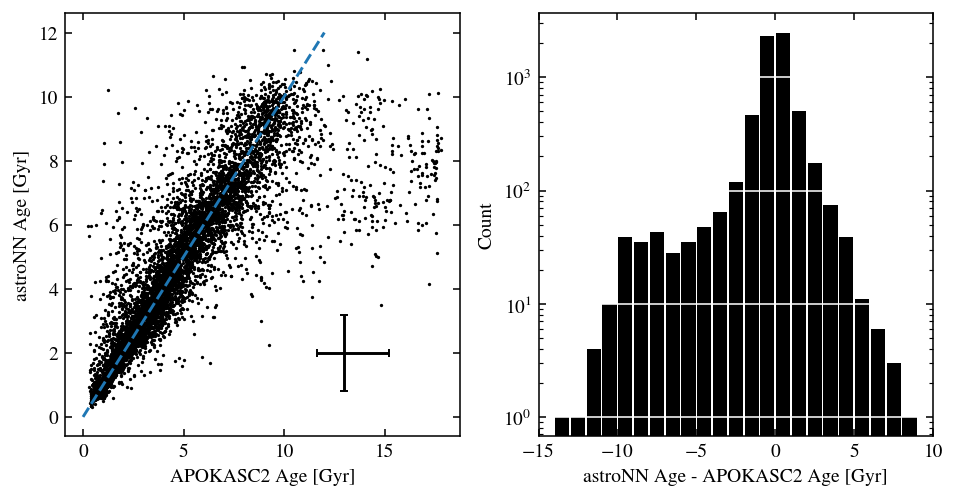

In [52]:
# Select targets with ages from both APOKASC and astroNN
ages = stellar_params[(pd.notna(stellar_params['APOKASC2_AGE'])) & (pd.notna(stellar_params['ASTRONN_AGE']))]

# APOKASC age vs astroNN age
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
ax.plot([0, 12], [0, 12], linestyle='--')
ax.scatter(ages['APOKASC2_AGE'], ages['ASTRONN_AGE'], s=0.5, c='k')
# plot RMS error
ax.errorbar(13, 2, 
            xerr=[[rms(ages['APOKASC2_AGE_MERR'])],
                  [rms(ages['APOKASC2_AGE_PERR'])]], 
            yerr=rms(ages['ASTRONN_AGE_ERR']),
            color='k', capsize=2)
ax.set_xlabel('APOKASC2 Age [Gyr]')
ax.set_ylabel('astroNN Age [Gyr]')

# Histrogram of age differences
ax = axs[1]
xmin = -15
xmax = 10
bins = np.linspace(xmin, xmax, 26)
ax.hist(ages['ASTRONN_AGE'] - ages['APOKASC2_AGE'], 
        color='k', bins=bins, rwidth=0.9)
ax.grid(which='major', axis='y', color='w')
ax.set_xlim((xmin, xmax))
ax.set_yscale('log')
ax.set_xlabel('astroNN Age - APOKASC2 Age [Gyr]')
ax.set_ylabel('Count')
plt.show()

In [53]:
# List of IDs for stars with big age differences
age_discrep = ages[ages['ASTRONN_AGE'] - ages['APOKASC2_AGE'] < -5]
age_discrep['AGE_DIFF'] = age_discrep['ASTRONN_AGE'] - age_discrep['APOKASC2_AGE']
age_discrep.to_csv('age_discrep.csv')

/apps/python/3.7-2019.10/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


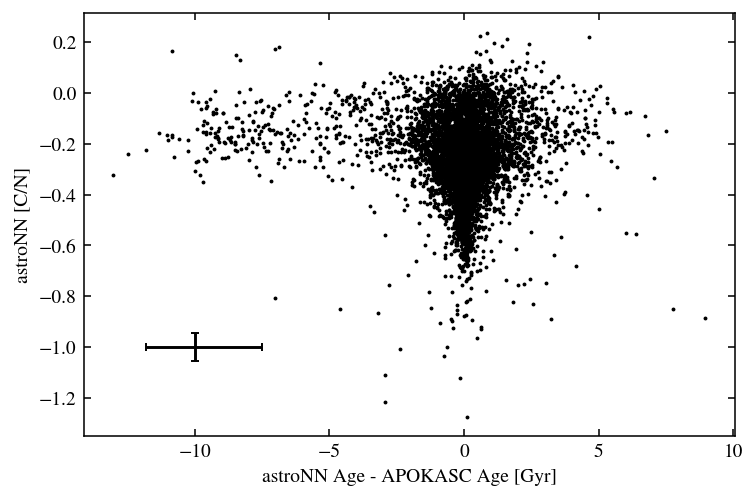

In [54]:
# Age difference vs C/N
fig, ax = plt.subplots()
ax.scatter(ages['ASTRONN_AGE'] - ages['APOKASC2_AGE'], 
           ages['ASTRONN_C_N'], c='k', s=1)
# plot RMS errors added in quadrature
ax.errorbar(-10, -1, 
            xerr=[[quad_add(rms(ages['APOKASC2_AGE_MERR']), rms(ages['ASTRONN_AGE_ERR']))],
                  [quad_add(rms(ages['APOKASC2_AGE_PERR']), rms(ages['ASTRONN_AGE_ERR']))]], 
            yerr=rms(ages['ASTRONN_C_N_ERR']),
            color='k', capsize=2)
ax.set_xlabel('astroNN Age - APOKASC Age [Gyr]')
ax.set_ylabel('astroNN [C/N]')
plt.savefig('agediff_CN.png')
plt.show()

### Alpha abundance comparison

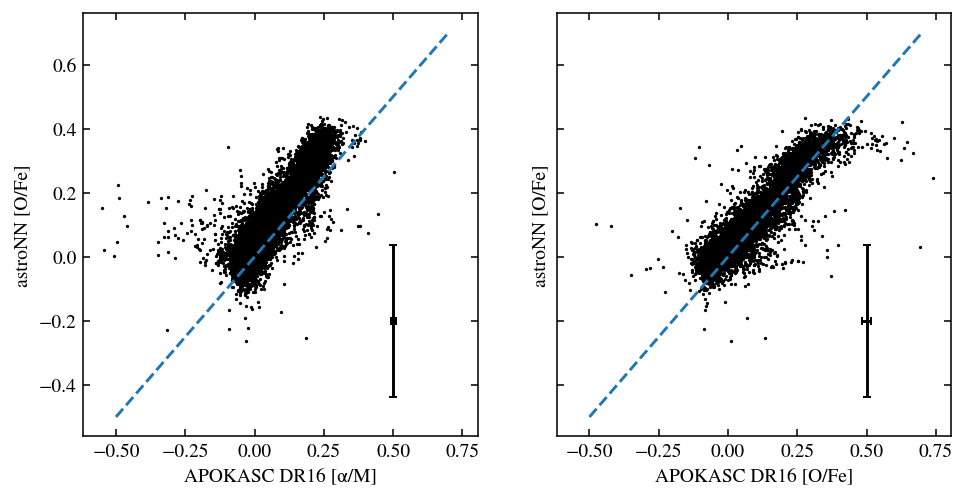

In [59]:
# select targets with alpha (O) abundances from APOKASC and astroNN
alphas = stellar_params[(pd.notna(stellar_params['DR16_ALP_M_COR'])) & (pd.notna(stellar_params['ASTRONN_O_FE']))]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(alphas['DR16_ALP_M_COR'], alphas['ASTRONN_O_FE'], c='k', s=0.5)
ax.plot([-0.5, 0.7], [-0.5, 0.7], linestyle='--')
ax.errorbar(0.5, -0.2, xerr=rms(alphas['DR16_ALP_M_COR_ERR']), yerr=rms(alphas['ASTRONN_O_FE_ERR']), capsize=2, color='k')
ax.set_xlabel('APOKASC DR16 [α/M]')
ax.set_ylabel('astroNN [O/Fe]')

ax = axs[1]
ax.scatter(alphas['DR16_O_FE'], alphas['ASTRONN_O_FE'], c='k', s=0.5)
ax.plot([-0.5, 0.7], [-0.5, 0.7], linestyle='--')
ax.errorbar(0.5, -0.2, xerr=rms(alphas['DR16_O_FE_ERR']), yerr=rms(alphas['ASTRONN_O_FE_ERR']), capsize=2, color='k')
ax.set_xlabel('APOKASC DR16 [O/Fe]')
ax.set_ylabel('astroNN [O/Fe]')
plt.show()

### Iron abundance / metallicity comparison

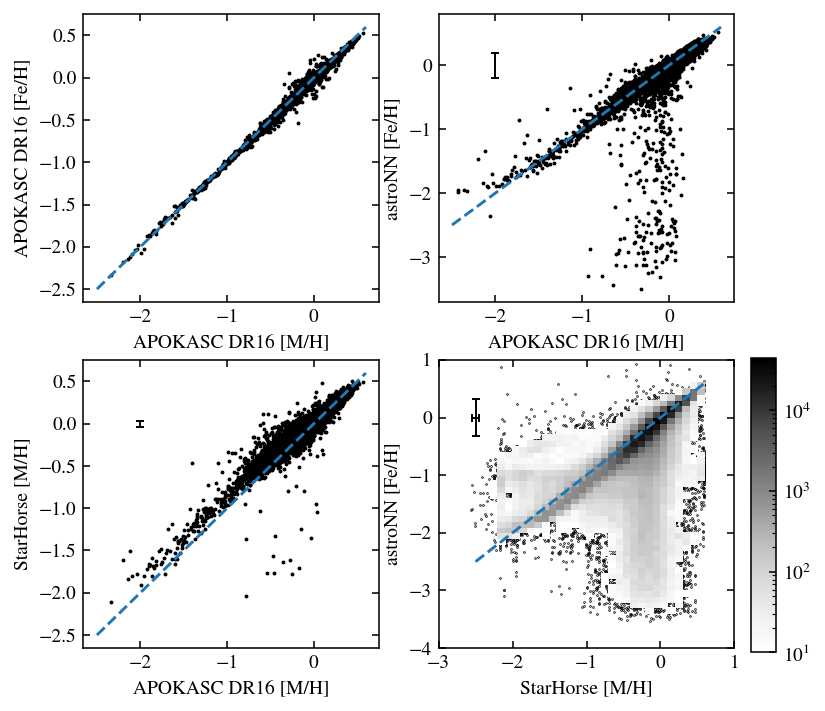

In [142]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# APOKASC Fe/H vs M/H
ax = axs[0, 0]
metals = stellar_params[(pd.notna(stellar_params['DR16_M_H_COR'])) & (pd.notna(stellar_params['DR16_FE_H']))]
ax.scatter(metals['DR16_M_H_COR'], metals['DR16_FE_H'], c='k', s=1)
# Reported errors are too small to be noticeable
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.set_xlabel('APOKASC DR16 [M/H]')
ax.set_ylabel('APOKASC DR16 [Fe/H]')

# APOKASC vs astroNN
ax = axs[0, 1]
metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['DR16_M_H_COR']))]
ax.scatter(metals['DR16_M_H_COR'], metals['ASTRONN_FE_H'], c='k', s=1)
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.errorbar(-2, 0, 
#             xerr=rms(metals['DR16M_H_COR_ERR']), 
            yerr=rms(metals['ASTRONN_FE_H_ERR']), 
            color='k', capsize=2, elinewidth=1)
# Weirdos cut: APOKASC - astroNN >= 0.5
# ax.plot([-0.7, 0.2], [-1.2, -0.3], linestyle='-', color='r')
ax.set_xlabel('APOKASC DR16 [M/H]')
ax.set_ylabel('astroNN [Fe/H]')

# APOKASC vs StarHorse
ax = axs[1, 0]
metals = stellar_params[(pd.notna(stellar_params['STARHORSE_M_H'])) & (pd.notna(stellar_params['DR16_FE_H']))]
ax.scatter(metals['DR16_M_H_COR'], metals['STARHORSE_M_H'], c='k', s=1)
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.errorbar(-2, 0, 
#             xerr=rms(metals['DR16_M_H_COR_ERR']),
            yerr=[[rms(metals['STARHORSE_M_H_MERR'])], [rms(metals['STARHORSE_M_H_PERR'])]],
            color='k', capsize=2, elinewidth=1)
# ax.plot([-2, 0.5], [-2, 0.5], linestyle='--')
ax.set_xlabel('APOKASC DR16 [M/H]')
ax.set_ylabel('StarHorse [M/H]')

ax = axs[1, 1]
metals = stellar_params[(pd.notna(stellar_params['ASTRONN_FE_H'])) & (pd.notna(stellar_params['STARHORSE_M_H']))]
metals.drop(metals[(metals['ASTRONN_FE_H'] < -4) | (metals['ASTRONN_FE_H'] > 1)].index, inplace=True)
metals.drop(metals[metals['ASTRONN_FE_H_ERR'] > 5].index, inplace=True)
ax.scatter(metals['STARHORSE_M_H'], metals['ASTRONN_FE_H'], c='k', s=.1)
hist, xedges, yedges, im = ax.hist2d(metals['STARHORSE_M_H'], metals['ASTRONN_FE_H'], 
                                     bins=[np.arange(-3, 1.1, 0.1), np.arange(-4, 1.1, 0.1)], 
                                     cmap='Greys', norm=colors.LogNorm(), cmin=10)
ax.plot([-2.5, 0.6], [-2.5, 0.6], linestyle='--')
ax.errorbar(-2.5, 0, 
            xerr=[[rms(metals['STARHORSE_M_H_MERR'])], [rms(metals['STARHORSE_M_H_PERR'])]],
            yerr=rms(metals['ASTRONN_FE_H_ERR']),
            color='k', capsize=2, elinewidth=1)
plt.subplots_adjust(right=0.9)
cax = plt.axes([0.92, 0.12, 0.03, 0.35])
plt.colorbar(im, cax=cax)
ax.set_xlabel('StarHorse [M/H]')
ax.set_ylabel('astroNN [Fe/H]')

plt.show()